In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import sklearn as sk

#pd.options.display.max_rows = 1000
#pd.options.display.max_columns = 20

#21: Sale (Dollars)
#23: Volume Sold (Gallons)
cols = [21,23]

#Group Decision for prelim analysis: use first million rows
rows = 1000000
dfinputdir = '/kaggle/input/iowaliquorclustering/Iowa_Liquor_Sales.csv'
df = pd.read_csv(dfinputdir,usecols=cols, nrows=rows).dropna()

#drop outliers
#df['Sale (Dollars)'] = pd.to_numeric(df['Sale (Dollars)'])
#df['Volume Sold (Gallons)'] = pd.to_numeric(df['Volume Sold (Gallons)'])


df = df[df['Sale (Dollars)'] < 60000]
df = df[df['Volume Sold (Gallons)'] < 650]

df.head()

,Sale (Dollars),Volume Sold (Gallons)
0,261.60,2.38
1,63.00,2.77
2,131.94,2.77
3,21.45,0.59
4,126.36,3.17


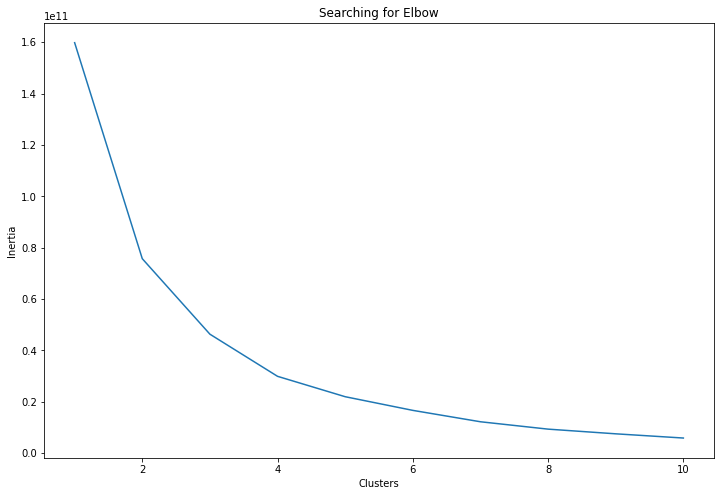

In [13]:
from sklearn.cluster import KMeans

clusters = []

for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(df)
    clusters.append(km.inertia_)
    
    
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


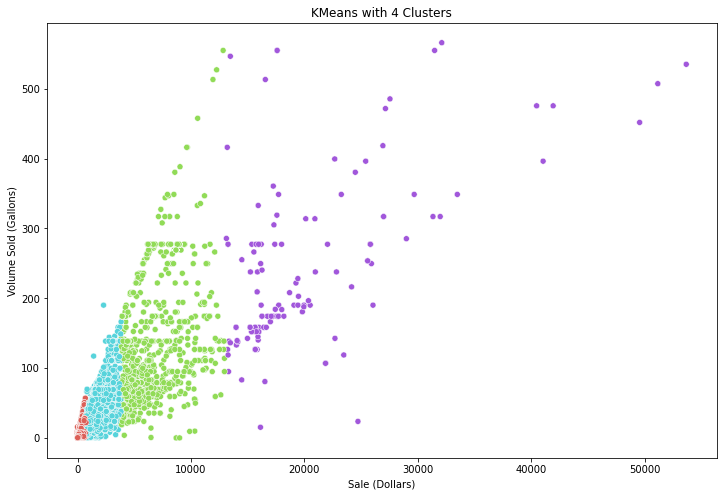

In [19]:
liq4 = KMeans(n_clusters=4).fit(df)

df['Labels'] = liq4.labels_

plt.figure(figsize=(12, 8))
sns.scatterplot(df['Sale (Dollars)'], df['Volume Sold (Gallons)'], hue=df['Labels'], 
                palette=sns.color_palette('hls', 4), legend = False)
plt.title('KMeans with 4 Clusters')
plt.show()

In [20]:
#13: Vendor Name
#18: State Bottle Cost
#19: State Bottle Retail
cols = [11,18,19]

#Must use MANY fewer rows for legibility; final version, sort on most frequent?
#rows = 50
dfinputdir = '/kaggle/input/iowaliquorclustering/Iowa_Liquor_Sales.csv'
df = pd.read_csv(dfinputdir,usecols=cols).dropna()
df.head()

df['Gross Margin'] = df['State Bottle Retail'] - df['State Bottle Cost']
top50 = df['Category Name'].value_counts()[:50].index.tolist()
top50

top50_df = df[df['Category Name'].isin(top50)]
top50_df = top50_df.groupby('Category Name', as_index = False).agg({'Gross Margin':['mean']})
top50_df.head()

,Category Name,Gross Margin
,,mean
0,100% Agave Tequila,9.471076
1,AMERICAN COCKTAILS,3.634179
2,AMERICAN DRY GINS,2.945318
3,AMERICAN GRAPE BRANDIES,2.676517
4,American Brandies,2.887201


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:9139: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  sort=sort,


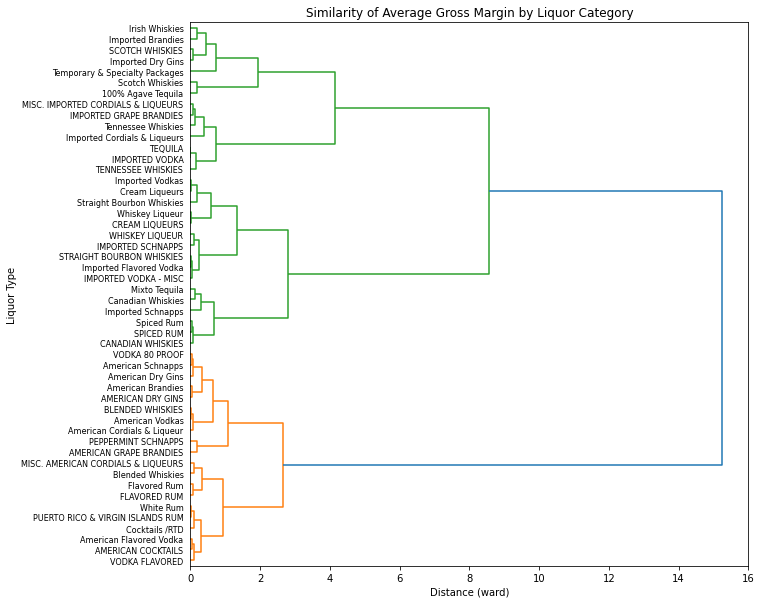

In [21]:
import scipy.cluster.hierarchy as shc
from sklearn import preprocessing
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import sklearn as sk

#brief visual check of encoding beyond pd.head()
#pd.set_option('display.max_rows', 5000) 

le = preprocessing.LabelEncoder()
temp = top50_df['Category Name']
df_code = pd.DataFrame(data = le.fit_transform(temp), columns=['Cat Name Code'])

df_joined = top50_df.join(other=df_code)
df_principal = df_joined.iloc[:,1:3]
df_principal.index = df_joined.iloc[:,0]

Z = shc.linkage(df_principal.iloc[:, [0]], method = 'ward')

#create correspondence and restore encoded labels?
plt.figure(figsize =(10, 10)) 
plt.title('Similarity of Average Gross Margin by Liquor Category')
plt.ylabel('Liquor Type')
plt.xlabel('Distance (ward)')
Dendrogram = shc.dendrogram(Z, orientation = 'right', labels = df_principal.index,  # rotates the x axis labels
    leaf_font_size=8.) 